## Introduction
----
Here I will convert the batch least squares solution approach to a recursive approach. Here's the following measurements data:

| Current (A) | Voltage (V) |
|-------------|-------------|
| 0.2         | 1.23        |
| 0.3         | 1.38        |
| 0.4         | 2.06        |
| 0.5         | 2.47        |
| 0.6         | 3.17        |

##### The algorithm for the recursive approach is as follows:
1. Initialize the estimator
2. Set up measurement model
3. Update the estimate and the covariance

This is going to include an offset **b** , $y = Rx + b$ and if Ohm's law ($V = RI$) holds, it is expected for the offset to be near zero.


Initial parameters are set with the assumption that the prior estimate of resistance $R=4$ is not very accurate.
Since it is fairly certain that Ohm's law ($V = RI$) does, in fact, hold, it is safe to assume with high confidence that the offset term $b$ will be close to zero.

The estimator will be initialized as follows:
$$\hat{R} \sim \mathcal{N}(4, 10.0), \hat{b} \sim \mathcal{N}(0, 0.2)$$

It is assumed that we know the current perfectly, and that the voltage measurements are corrupted by additive, independent and identitically distributed Gaussian noise with variance $0.0225 ~ V^2$.

## Data preparation
----
As before, load the current and voltge measurements into numpy arrays:

In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

I = np.array([0.2, 0.3, 0.4, 0.5, 0.6])
V = np.array([1.23, 1.38, 2.06, 2.47, 3.17])

### Visualize the data

Probability density functions of earler defined estimates

The probability density function (**PDF**) shows the likelihood of the variable to have that value (that is _**mean**_). _**Variance**_ simply means noise.

For example, the initial value of **R** will most likely be **4** and the variace **10** will describe the noise (that is those values are less likely to happen). 

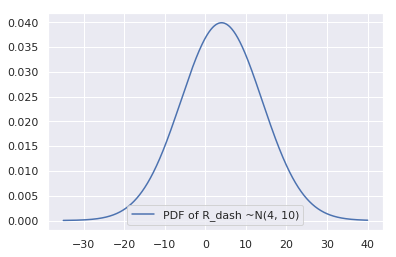

In [2]:
from scipy.stats import norm

# resistance estimate PDF
x_axis = np.arange(-35, 40, 0.001)
mean = 4 
SD = 10.0

plt.plot(x_axis, norm.pdf(x_axis,mean,SD), label='PDF of R_dash ~N(4, 10)')
plt.legend()
plt.show()

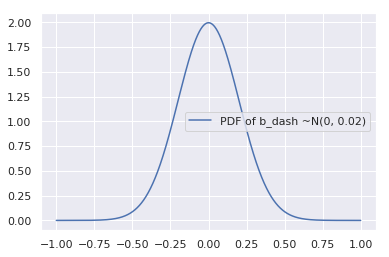

In [3]:
# offset estimate PDF
x_axis = np.arange(-1, 1, 0.001)
mean = 0 
SD = 0.2

plt.plot(x_axis, norm.pdf(x_axis,mean,SD), label='PDF of b_dash ~N(0, 0.02)')
plt.legend()
plt.show()

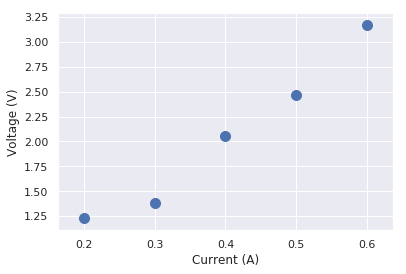

In [4]:
x_label = 'Current (A)'
y_label = 'Voltage (V)'

plt.scatter(I, V, s=100)

plt.xlabel(x_label)
plt.ylabel(y_label)

plt.grid(True)
plt.show()

## Estimating the Parameters
----
### Batch Estimator
Before implementing recursive least squares, let's review the parameter estimate given by the batch least squares method used in the previous assignment. This time, you will be fitting a model which contains an offset $y = Rx + b$. We can use this result later for comparison.

The parameters of the line fit are ([Resistance R, offset b]):
[4.97  0.074]


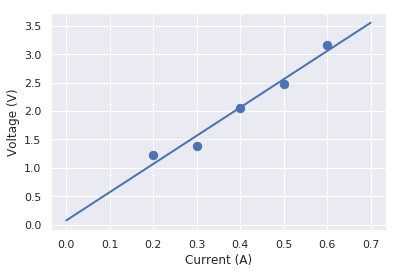

In [5]:
## Batch Least Squares Approach

# Jacobian matrix
H = np.ones((5,2)) 
H[:, 0] = I

x_ls = inv(H.T.dot(H)).dot(H.T.dot(V))
print('The parameters of the line fit are ([Resistance R, offset b]):')
print(x_ls)

# Visualized linear estimator
x_label = 'Current (A)'
y_label = 'Voltage (V)'

I_line = np.arange(0, 0.8, 0.1)
V_line = x_ls[0]*I_line + x_ls[1]

plt.scatter(I, V, s=70)
plt.plot(I_line, V_line, lw=2)

plt.xlabel(x_label)
plt.ylabel(y_label)

plt.grid(True)
plt.show()

As expected, the offset parameter $\hat{b}$ is near zero, while $\hat{R}$ closely approximates the true resistance value of $R = 5~\Omega$.

### Recursive Estimator

##### Sources
- Source of the algorithm (start on page 3): http://web.cs.iastate.edu/~cs577/handouts/recursive-least-squares.pdf

- Noise covariance additional material (based on Kalman filter): https://www.diva-portal.org/smash/get/diva2:1041201/FULLTEXT01.pdf

##### Notes:

- Tips on when to use _numpy.dot()_ or _numpy.matmul()_ or _@_ or *: https://numpy.org/doc/stable/reference/generated/numpy.dot.html#numpy.dot

Now let's implement the batch least aquares method recursively.

**Initialized parameter and covariance estimates**:

----
$$
\hat{\mathbf{x}}_0 = E\left[\mathbf{x}\right] \,\,\, , \,\,\, \mathbf{P}_0 = E\left[(\mathbf{x} - \hat{\mathbf{x}}_0)(\mathbf{x} - \hat{\mathbf{x}}_0)^T\right]
$$

**For every measurement k**:

----
  * Calculate the correction gain $$\mathbf{K}_k = \mathbf{P}_{k-1}\mathbf{H}_k^T\left(\mathbf{H}_k\mathbf{P}_{k-1}\mathbf{H}_k^T + \mathbf{R}_k\right)^{-1}$$
  * Update the parameter estimate $$\hat{\mathbf{x}}_k = \hat{\mathbf{x}}_{k-1} + \mathbf{K}_k\left(\mathbf{y}_k - \mathbf{H}_k\hat{\mathbf{x}}_{k-1}\right)$$
  * Update the covariance estimate $$\mathbf{P}_k = \left(\mathbf{I} - \mathbf{K}_k\mathbf{H}_k\right)\mathbf{P}_{k-1}$$
  
$$\mathbf{K}_k - estimator\ gain\ matrix $$
$$\mathbf{P}_k - estimation-error\ covariance $$
$$\mathbf{R}_k - voltage\ additive,\ independent\ and\ identically\ distributed\ Gaussian\ noise\ with\ variance\ (scalar) $$
$$\mathbf{y}_k - voltage\ V $$
$$\mathbf{H}_k - measurment\ vector $$
$$\hat{\mathbf{x}}_k - parameter\ estimate $$
 

In [6]:
## Recursive solution - sources provided in the description

#------------------------

#Initialize the 2x2 covaraince matrix
P_k = np.array([[10., 0.],[0., 0.2]])

#Initialize the parameter estimate x
x_k = np.array([4., 0.])

# Rk
var = 0.0225

#Pre allocate our solutions so we can save the estimate at every step
num_measurements = I.shape[0]
x_history = np.zeros(shape=(num_measurements + 1, 2))
P_history = np.zeros(shape=(num_measurements + 1, 2, 2))

x_history[0] = x_k
P_history[0] = P_k

identity = np.eye(2)

#------------------------

print(f'\nInit step')
print('\n2x2 asymptotic variance covaraince matrix')
print(P_k)

print('\nParameter estimate x_k')
print(x_k)

print('\nMeasurment variance R_k (scalar)')
print(var)

print('\nPlaceholders for x_k and P_k')
print(f'Shape of x_history: {x_history.shape}')
print(f'Shape of P_history: {P_history.shape}')

#------------------------

#Iterate over the measurements
for k in range(num_measurements):
    #Construct H_k
    H_k = np.array([[I[k], 1.]])
  
    #Construct K_k
    K_k = P_k @ H_k.T @ inv(H_k @ P_k @ H_k.T + var)
                    
    #Update our estimate
    y_k = V[k]
    x_k = x_k + K_k @ (y_k - H_k @ x_k)
 
    #Update our uncertainty
    P_k = (identity - K_k @ H_k) @ P_k

    #Keep track of our history
    P_history[k+1] = P_k
    x_history[k+1] = x_k
    
#------------------------
    
print('\nThe parameters of the line fit are ([R, b]):')
print(x_k)


Init step

2x2 asymptotic variance covaraince matrix
[[10.   0. ]
 [ 0.   0.2]]

Parameter estimate x_k
[4. 0.]

Measurment variance R_k (scalar)
0.0225

Placeholders for x_k and P_k
Shape of x_history: (6, 2)
Shape of P_history: (6, 2, 2)

The parameters of the line fit are ([R, b]):
[4.97896278 0.06886542]


## Plotting the Results
----
Let's plot out the solutions at every step.

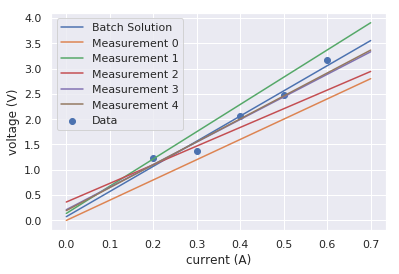

In [7]:
#Plot
plt.scatter(I, V, label='Data')
plt.plot(I_line, V_line, label='Batch Solution')
plt.xlabel('current (A)')
plt.ylabel('voltage (V)')
plt.grid(True)

I_line = np.arange(0, 0.8, 0.1)
for k in range(num_measurements):
    V_line = x_history[k,0]*I_line + x_history[k,1]
    plt.plot(I_line, V_line, label='Measurement {}'.format(k))

plt.legend()
plt.show()

The resistance estimate does approach the true resistance value of $R = 5~\Omega$.